<a href="https://colab.research.google.com/github/seowon98/VGG16_cifar_pytorch/blob/master/VGG_Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn

import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

In [2]:
def loss_tracker(loss_plot, loss_value, num):
    '''num, loss_value, are Tensor'''
    vis.line(X=num,
             Y=loss_value,
             win = loss_plot,
             update='append'
             )

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

In [4]:
device

'cuda'

In [5]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


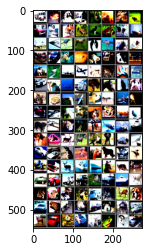

truck   dog horse truck


In [6]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
#vis.images(images/2 + 0.5)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [7]:
import torchvision.models.vgg as vgg

In [8]:
cfg = [32,32,'M', 64,64,128,128,128,'M',256,256,256,512,512,512,'M'] #13 + 3 =vgg16

In [9]:
class VGG(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096), #
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096), #
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes), #
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        #x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [10]:
vgg16= VGG(vgg.make_layers(cfg),10,True).to(device)

In [11]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=

In [12]:
a=torch.Tensor(1,3,32,32).to(device)
out = vgg16(a)
print(out)

tensor([[ 1.3144e+36, -3.2714e+35, -1.4812e+36,  1.2724e+36,  8.5739e+35,
          3.1300e+35,  3.9079e+35,  1.4802e+36, -7.1855e+35,  1.8418e+36]],
       device='cuda:0', grad_fn=<AddmmBackward>)


In [13]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(vgg16.parameters(), lr = 0.01,momentum=0.9,weight_decay=5e-4)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

In [14]:
print(len(trainloader))
epochs = 200

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    print('Epoch:', epoch,'LR:', exp_lr_scheduler.get_last_lr())
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches            
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0
    exp_lr_scheduler.step()
print('Finished Training') # [200,    90] loss: 0.162 

391
Epoch: 0 LR: [0.01]
[1,    50] loss: 2.274
[1,   100] loss: 2.166
[1,   150] loss: 2.076
[1,   200] loss: 2.061
[1,   250] loss: 1.977
[1,   300] loss: 1.936
[1,   350] loss: 1.845
Epoch: 1 LR: [0.01]
[2,    50] loss: 1.783
[2,   100] loss: 1.780
[2,   150] loss: 1.724
[2,   200] loss: 1.703
[2,   250] loss: 1.627
[2,   300] loss: 1.651
[2,   350] loss: 1.612
Epoch: 2 LR: [0.01]
[3,    50] loss: 1.570
[3,   100] loss: 1.545
[3,   150] loss: 1.524
[3,   200] loss: 1.495
[3,   250] loss: 1.481
[3,   300] loss: 1.427
[3,   350] loss: 1.421
Epoch: 3 LR: [0.01]
[4,    50] loss: 1.366
[4,   100] loss: 1.328
[4,   150] loss: 1.325
[4,   200] loss: 1.335
[4,   250] loss: 1.309
[4,   300] loss: 1.289
[4,   350] loss: 1.244
Epoch: 4 LR: [0.01]
[5,    50] loss: 1.213
[5,   100] loss: 1.232
[5,   150] loss: 1.168
[5,   200] loss: 1.157
[5,   250] loss: 1.147
[5,   300] loss: 1.154
[5,   350] loss: 1.142
Epoch: 5 LR: [0.01]
[6,    50] loss: 1.099
[6,   100] loss: 1.063
[6,   150] loss: 1.089
[6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


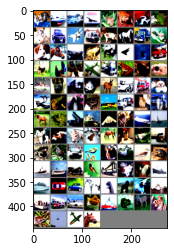

GroundTruth:    cat  ship  ship plane


In [15]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [16]:
outputs = vgg16(images.to(device))

In [17]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


In [18]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = vgg16(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()
#Accuracy of the network on the 10000 test images: 76 % -> 91%
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total)) 

Accuracy of the network on the 10000 test images: 91 %
